In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import matplotlib.pyplot as plt
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

In [2]:
@njit
def dynamics(t, state):
    """
    Defines the system of ODEs for projectile motion.
    
    Parameters
    ----------
    state : 1D array
        State vector [x, y, vx, vy].

    t : float
        Not needed (only for completeness)
    
    Returns
    -------
    1D array
        Derivatives [vx, vy, ax, ay].
    """
    vx, vy = state[2], state[3]
    ax, ay = 0, -9.8
    return np.array([vx, vy, ax, ay], dtype=np.float64)

# Shooting Method

### Function Definitions

In [3]:
@njit
def rk4(init_state, tf, step_size):
    """
    Performs Runge-Kutta 4th order integration for projectile motion.
    
    Parameters
    ----------
    init_state : 1D array
        Initial state vector [x0, y0, vx0, vy0].
    tf : float
        Final time.
    step_size : float
        Integration step size.
    
    Returns
    -------
    tuple
        Time array, x array, y array, vx array, vy array.
    """
    t0 = 0
    n_steps = int((tf - t0) / step_size)  # Number of time steps
    t_vals = np.zeros(n_steps)
    state_vals = np.zeros((n_steps, 4))
    
    t = t0
    state = init_state

    for i in range(n_steps):
        k1 = step_size * dynamics(t, state)
        k2 = step_size * dynamics(t + step_size / 2, state + k1 / 2)
        k3 = step_size * dynamics(t + step_size / 2, state + k2 / 2)
        k4 = step_size * dynamics(t + step_size, state + k3)
        
        state = state + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        t += step_size
        
        t_vals[i] = t
        state_vals[i] = state
        
    x, y, vx, vy = state_vals[:, 0], state_vals[:, 1], state_vals[:, 2], state_vals[:, 3]
    return t_vals, x, y, vx, vy

@njit
def compute_errors(vx_guess, vy_guess, target_x, target_y, final_time, step_size):
    """
    Computes the errors between the final position and the target position.
    
    Parameters
    ----------
    vx_guess : float
        Guess for initial velocity in x direction.
    vy_guess : float
        Guess for initial velocity in y direction.
    target_x : float
        Target x position.
    target_y : float
        Target y position.
    final_time : float
        Final time of simulation.
    step_size : float
        Integration step size.
    
    Returns
    -------
    1D array
        Errors [error_x, error_y].
    """
    initial_state = np.array([0, 0, vx_guess, vy_guess], dtype=np.float64)
    _, x, y, _, _ = rk4(initial_state, final_time, step_size)
    final_x, final_y = x[-1], y[-1]
    return np.array([target_x - final_x, target_y - final_y], dtype=np.float64)

def shooting_method(target_pos, final_time, initial_guess, tol, step_size):
    """
    Finds the correct initial velocity using the shooting method.
    
    Parameters
    ----------
    target_pos : 1D array
        Target position [x_target, y_target].
    final_time : float
        Final time of simulation.
    initial_guess : 1D array
        Initial guess for velocities [vx_guess, vy_guess].
    tol : float
        Tolerance for convergence.
    step_size : float
        Integration step size.
    
    Returns
    -------
    1D array
        Correct initial velocities [vx, vy].
    """
    target_x, target_y = target_pos
    guess = np.array(initial_guess, dtype=np.float64)  # Ensure initial guess is float
    delta_v = np.array([1.0, 1.0], dtype=np.float64)   # Ensure delta_v is float
    
    while np.linalg.norm(delta_v) > tol:
        errors = compute_errors(guess[0], guess[1], target_x, target_y, final_time, step_size)
        
        if np.linalg.norm(errors) < tol:
            break
        
        errors_x_plus = compute_errors(guess[0] + delta_v[0], guess[1], target_x, target_y, final_time, step_size)
        errors_y_plus = compute_errors(guess[0], guess[1] + delta_v[1], target_x, target_y, final_time, step_size)
        
        jacobian = np.array([
            [(errors_x_plus[0] - errors[0]) / delta_v[0], (errors_y_plus[0] - errors[0]) / delta_v[1]],
            [(errors_x_plus[1] - errors[1]) / delta_v[0], (errors_y_plus[1] - errors[1]) / delta_v[1]]
        ], dtype=np.float64)  # Ensure Jacobian matrix is float
        
        delta_v = -np.linalg.inv(jacobian).dot(errors)
        guess += delta_v
    
    return guess

### Parameters

In [4]:
t_final = 15                # Final time of simulation
step_size = 0.1             # Time step for RK4 integration
target_pos = np.array([1000, -100], dtype=np.float64)  # Target position [x_target, y_target]
initial_guess = np.array([2, 10], dtype=np.float64)    # Initial guess for velocities [vx_guess, vy_guess]
tolerance = 1e-10             # Convergence tolerance`

### Solving

In [5]:
%%time
# Computing the initial velocity using shooting method
optimal_velocity = shooting_method(target_pos, t_final, initial_guess, tolerance, step_size)

CPU times: user 1.27 s, sys: 125 ms, total: 1.39 s
Wall time: 1.41 s


### Results

In [6]:
# Simulating the trajectory with the optimal initial velocity
time_vals, x_vals, y_vals, vx_vals, vy_vals = rk4(
    np.array([0, 0, optimal_velocity[0], optimal_velocity[1]]), t_final, step_size
)

x_final = x_vals[-1]
y_final = y_vals[-1]
vx_final = vx_vals[-1]
vy_final = vy_vals[-1]

print('Initial positions : xi = {} m, yi = {}'.format(x_vals[0], y_vals[0]))
print('Initial velocities: vx = {} m/s, vy = {}'.format(optimal_velocity[0], optimal_velocity[1]))
print()
print('Final positions  : xf = {} m, yf = {}'.format(x_final, y_final))
print('Final velocities : vx = {} m/s, vy = {}'.format(vx_final, vy_final))

Initial positions : xi = 6.666666666666669 m, yi = 6.634333333333338
Initial velocities: vx = 66.66666666666667 m/s, vy = 66.83333333333337

Final positions  : xf = 999.9999999999978 m, yf = -99.99999999999804
Final velocities : vx = 66.66666666666667 m/s, vy = -80.16666666666652


### Plot

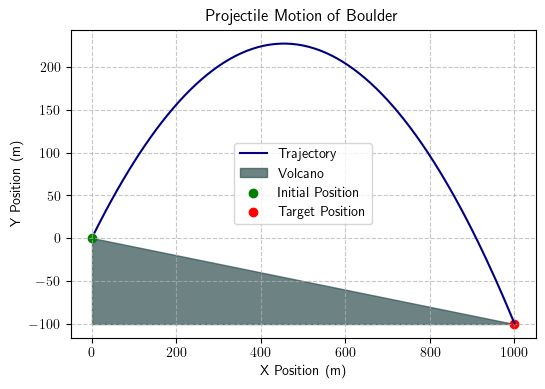

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, label='Trajectory', color='navy')
mountain_x = [0, 0, 1000]  # X coordinates of the triangle vertices
mountain_y = [0, -100, -100]     # Y coordinates of the triangle vertices 
plt.fill(mountain_x, mountain_y, color='darkslategray', alpha=0.7, label='Volcano')
plt.scatter(0, 0, color='green', label='Initial Position')
plt.scatter(target_pos[0], target_pos[1], color='red', label='Target Position')
plt.title('Projectile Motion of Boulder')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('shooting_0.1.pdf')
plt.show()

#### Higher step sizes

### Parameters

In [8]:
t_final = 15                # Final time of simulation
step_size = 1             # Time step for RK4 integration
target_pos = np.array([1000, -100], dtype=np.float64)  # Target position [x_target, y_target]
initial_guess = np.array([2, 10], dtype=np.float64)    # Initial guess for velocities [vx_guess, vy_guess]
tolerance = 1e-10             # Convergence tolerance`

### Solving

In [9]:
%%time
# Computing the initial velocity using shooting method
optimal_velocity = shooting_method(target_pos, t_final, initial_guess, tolerance, step_size)

CPU times: user 613 ms, sys: 42.8 ms, total: 656 ms
Wall time: 659 ms


### Results

In [10]:
# Simulating the trajectory with the optimal initial velocity
time_vals, x_vals, y_vals, vx_vals, vy_vals = rk4(
    np.array([0, 0, optimal_velocity[0], optimal_velocity[1]]), t_final, step_size
)

x_final = x_vals[-1]
y_final = y_vals[-1]
vx_final = vx_vals[-1]
vy_final = vy_vals[-1]

print('Initial positions : xi = {} m, yi = {}'.format(x_vals[0], y_vals[0]))
print('Initial velocities: vx = {} m/s, vy = {}'.format(optimal_velocity[0], optimal_velocity[1]))
print()
print('Final positions  : xf = {} m, yf = {}'.format(x_final, y_final))
print('Final velocities : vx = {} m/s, vy = {}'.format(vx_final, vy_final))

Initial positions : xi = 66.66666666666667 m, yi = 61.93333333333331
Initial velocities: vx = 66.66666666666667 m/s, vy = 66.83333333333331

Final positions  : xf = 999.9999999999998 m, yf = -100.00000000000004
Final velocities : vx = 66.66666666666667 m/s, vy = -80.16666666666666


### Plot

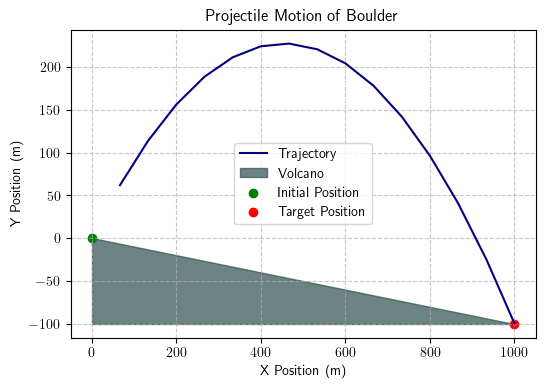

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, label='Trajectory', color='navy')
mountain_x = [0, 0, 1000]  # X coordinates of the triangle vertices
mountain_y = [0, -100, -100]     # Y coordinates of the triangle vertices 
plt.fill(mountain_x, mountain_y, color='darkslategray', alpha=0.7, label='Volcano')
plt.scatter(0, 0, color='green', label='Initial Position')
plt.scatter(target_pos[0], target_pos[1], color='red', label='Target Position')
plt.title('Projectile Motion of Boulder')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('shooting_1.pdf')
plt.show()

### Parameters

In [12]:
t_final = 15                # Final time of simulation
step_size = 6             # Time step for RK4 integration
target_pos = np.array([1000, -100], dtype=np.float64)  # Target position [x_target, y_target]
initial_guess = np.array([2, 10], dtype=np.float64)    # Initial guess for velocities [vx_guess, vy_guess]
tolerance = 1e-10             # Convergence tolerance`

### Solving

In [13]:
%%time
# Computing the initial velocity using shooting method
optimal_velocity = shooting_method(target_pos, t_final, initial_guess, tolerance, step_size)

CPU times: user 276 µs, sys: 24 µs, total: 300 µs
Wall time: 248 µs


### Results

In [14]:
# Simulating the trajectory with the optimal initial velocity
time_vals, x_vals, y_vals, vx_vals, vy_vals = rk4(
    np.array([0, 0, optimal_velocity[0], optimal_velocity[1]]), t_final, step_size
)

x_final = x_vals[-1]
y_final = y_vals[-1]
vx_final = vx_vals[-1]
vy_final = vy_vals[-1]

print('Initial positions : xi = {} m, yi = {}'.format(x_vals[0], y_vals[0]))
print('Initial velocities: vx = {} m/s, vy = {}'.format(optimal_velocity[0], optimal_velocity[1]))
print()
print('Final positions  : xf = {} m, yf = {}'.format(x_final, y_final))
print('Final velocities : vx = {} m/s, vy = {}'.format(vx_final, vy_final))

Initial positions : xi = 500.0 m, yi = 126.40000000000002
Initial velocities: vx = 83.33333333333333 m/s, vy = 50.46666666666667

Final positions  : xf = 1000.0 m, yf = -99.99999999999999
Final velocities : vx = 83.33333333333333 m/s, vy = -67.13333333333334


### Plot

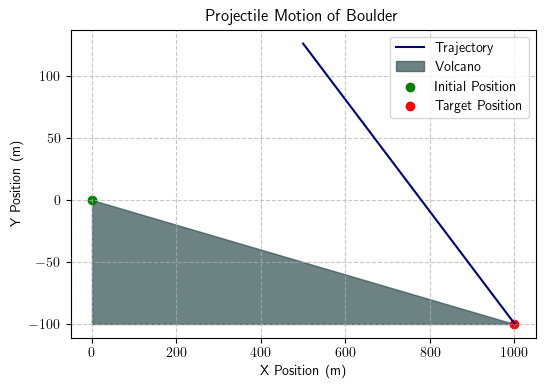

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, label='Trajectory', color='navy')
mountain_x = [0, 0, 1000]  # X coordinates of the triangle vertices
mountain_y = [0, -100, -100]     # Y coordinates of the triangle vertices 
plt.fill(mountain_x, mountain_y, color='darkslategray', alpha=0.7, label='Volcano')
plt.scatter(0, 0, color='green', label='Initial Position')
plt.scatter(target_pos[0], target_pos[1], color='red', label='Target Position')
plt.title('Projectile Motion of Boulder')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('shooting_6.pdf')
plt.show()

# Relaxation Method

### Function Definitions

In [16]:
@njit
def relaxation_method(x_start, x_end, y_start, y_end, num_var, step_size, time_vals, error_tolerance, max_iterations, initial_guess):
    """
    Performs the relaxation method to numerically solve the motion problem.
    
    Parameters
    ----------
    x_start : float
        Initial x position.
    x_end : float
        Final x position.
    y_start : float
        Initial y position.
    y_end : float
        Final y position.
    num_var : int
        Number of variables (position and velocity in x and y directions).
    step_size : float
        Step size for time intervals.
    time_vals : 1D array
        Array of time values.
    error_tolerance : float
        Tolerance for the relaxation method to stop.
    max_iterations : int
        Maximum allowed iterations to control the number of updates.
    initial_guess : 1D array
        Initial guess for positions and velocities.
    
    Returns
    -------
    y_vals : 2D array
        Array containing the values of positions and velocities at different time steps.
    """
    
    # Initialize the y matrix to store values of position and velocity for each time step
    y_vals = np.zeros((num_var, len(time_vals)))
    
    # Set initial values based on the provided initial guess
    y_vals[:, 0] = initial_guess
    
    # Initialize the error vector
    errors = np.ones(num_var * len(time_vals))
    
    # Main loop of the relaxation method
    iterations = 0
    while np.max(errors) > error_tolerance and iterations < max_iterations:
        # Reset error vector
        errors = np.zeros(num_var * len(time_vals))
        
        # Populate the error vector for each step
        k = 1
        for i in range(2, num_var * len(time_vals) - 2, num_var):
            # Calculate error at step k using current and previous values
            errors[i:i+num_var] = y_vals[:, k] - y_vals[:, k-1] - (
                step_size * dynamics(0.5 * (time_vals[k] + time_vals[k-1]), 0.5 * (y_vals[:, k] + y_vals[:, k-1]))
            )
            k += 1
        
        # Apply boundary conditions
        errors[0], errors[1] = y_vals[0, 0] - x_start, y_vals[1, 0] - y_start
        errors[-2], errors[-1] = y_vals[0, -1] - x_end, y_vals[1, -1] - y_end
        
        # Create the Jacobian matrix 
        jacobian = np.zeros((num_var * len(time_vals), num_var * len(time_vals)))
        
        # Fill the Jacobian with partial derivatives
        toggle = 0
        for i in range(2, (len(time_vals) * num_var) - 2, num_var):
            # Populate Jacobian for inner points
            jacobian[i, toggle:toggle+8] = [-1, 0, -step_size/2, 0, 1, 0, -step_size/2, 0]
            jacobian[i+1, toggle:toggle+8] = [0, -1, 0, -step_size/2, 0, 1, 0, -step_size/2]
            jacobian[i+2, toggle:toggle+8] = [0, 0, -1, 0, 0, 0, 1, 0]
            jacobian[i+3, toggle:toggle+8] = [0, 0, 0, -1, 0, 0, 0, 1]
            toggle += 4
        
        # Set Jacobian boundary conditions
        jacobian[0, :] = jacobian[1, :] = jacobian[-2, :] = jacobian[-1, :] = 0
        jacobian[0, 0] = 1
        jacobian[1, 1] = 1
        jacobian[-2, -4] = 1
        jacobian[-1, -3] = 1
        
        # Solve for the corrections (dy values)
        dy_vals = np.linalg.solve(jacobian, -errors)
        
        # Update y values using the correction
        for k in range(len(time_vals)):
            y_vals[:, k] += dy_vals[4 * k: 4 * k + 4]
        
        iterations += 1
    
    return y_vals

### Parameters

In [17]:
# Defining constants and initial conditions
num_var = 4  # Number of variables: x, y, vx, vy
time_start, time_end = 0, 15  # Start and end time
step_size = 0.1  
time_vals = np.arange(time_start, time_end + step_size, step_size)  # Time array
error_tolerance = 1e-10  # Error tolerance for convergence
max_iterations = 500  # Maximum number of iterations

# Boundary conditions
x_start, x_end = 0, 1000  # Initial and final x positions
y_start, y_end = 0, -100   # Initial and final y positions

initial_guess = np.array([x_start, y_start, 10.0, 10.0], dtype=np.float64)

### Solving

In [18]:
%%time

y_vals = relaxation_method(x_start, x_end, y_start, y_end, num_var, step_size, time_vals, error_tolerance, max_iterations, initial_guess)

CPU times: user 2.19 s, sys: 47 ms, total: 2.24 s
Wall time: 2.22 s


### Results

In [19]:
print('Initial positions  : x_start = ', y_vals[0, 0], 'm, y_start = ', y_vals[1, 0], 'm')
print('Initial velocities : vx = ', y_vals[2, 0], 'm/s, vy = ', y_vals[3, 0], 'm/s')
print()
print('Final positions    : x_end = ', y_vals[0, -1], 'm, y_end = ', y_vals[1, -1], 'm')
print('Final velocities   : vx = ', y_vals[2, -1], 'm/s, vy = ', y_vals[3, -1], 'm/s')

Initial positions  : x_start =  0.0 m, y_start =  0.0 m
Initial velocities : vx =  66.66666666666666 m/s, vy =  66.83333333333334 m/s

Final positions    : x_end =  1000.0 m, y_end =  -100.0 m
Final velocities   : vx =  66.66666666666666 m/s, vy =  -80.16666666666667 m/s


### Plot

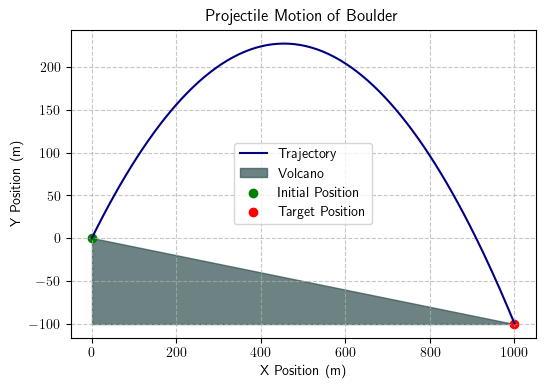

In [20]:
# Extracting x and y values for plotting
x_vals = y_vals[0, :]  # X positions
y_vals_plot = y_vals[1, :]  # Y positions

# Target position (final position of the projectile)
target_pos = (x_end, y_end)

# Plotting the trajectory along with the volcano and target position
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals_plot, label='Trajectory', color='navy')

# Plotting the volcano as a triangle
mountain_x = [0, 0, 1000]  # X coordinates of the triangle vertices
mountain_y = [0, -100, -100]  # Y coordinates of the triangle vertices 
plt.fill(mountain_x, mountain_y, color='darkslategray', alpha=0.7, label='Volcano')

# Plotting the initial and target positions
plt.scatter(0, 0, color='green', label='Initial Position')
plt.scatter(target_pos[0], target_pos[1], color='red', label='Target Position')

# Plot settings
plt.title('Projectile Motion of Boulder')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('relaxation_0.1.pdf')
plt.show()

### higher step size

### Parameters

In [21]:
# Defining constants and initial conditions
num_var = 4  # Number of variables: x, y, vx, vy
time_start, time_end = 0, 15  # Start and end time
step_size = 1  # Increased step size to reduce mesh points (was trying with 0.01 earlier to match shooting method)
time_vals = np.arange(time_start, time_end + step_size, step_size)  # Time array
error_tolerance = 1e-10  # Error tolerance for convergence
max_iterations = 500  # Maximum number of iterations

# Boundary conditions
x_start, x_end = 0, 1000  # Initial and final x positions
y_start, y_end = 0, -100   # Initial and final y positions

initial_guess = np.array([x_start, y_start, 10.0, 10.0], dtype=np.float64)

### Solving

In [22]:
%%time

y_vals = relaxation_method(x_start, x_end, y_start, y_end, num_var, step_size, time_vals, error_tolerance, max_iterations, initial_guess)

CPU times: user 913 ms, sys: 3.14 ms, total: 916 ms
Wall time: 915 ms


### Results

In [23]:
print('Initial positions  : x_start = ', y_vals[0, 0], 'm, y_start = ', y_vals[1, 0], 'm')
print('Initial velocities : vx = ', y_vals[2, 0], 'm/s, vy = ', y_vals[3, 0], 'm/s')
print()
print('Final positions    : x_end = ', y_vals[0, -1], 'm, y_end = ', y_vals[1, -1], 'm')
print('Final velocities   : vx = ', y_vals[2, -1], 'm/s, vy = ', y_vals[3, -1], 'm/s')

Initial positions  : x_start =  0.0 m, y_start =  0.0 m
Initial velocities : vx =  66.66666666666667 m/s, vy =  66.83333333333334 m/s

Final positions    : x_end =  1000.0 m, y_end =  -100.0 m
Final velocities   : vx =  66.66666666666667 m/s, vy =  -80.16666666666667 m/s


### Plot

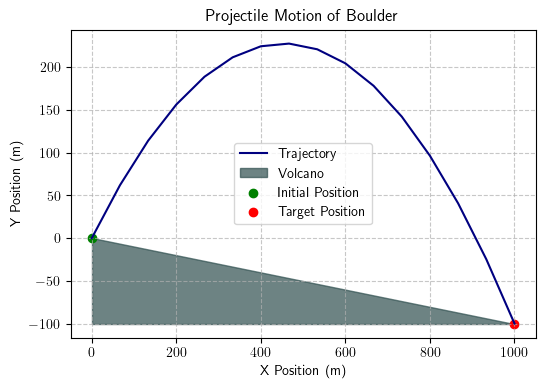

In [24]:
# Extracting x and y values for plotting
x_vals = y_vals[0, :]  # X positions
y_vals_plot = y_vals[1, :]  # Y positions

# Target position (final position of the projectile)
target_pos = (x_end, y_end)

# Plotting the trajectory along with the volcano and target position
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals_plot, label='Trajectory', color='navy')

# Plotting the volcano as a triangle
mountain_x = [0, 0, 1000]  # X coordinates of the triangle vertices
mountain_y = [0, -100, -100]  # Y coordinates of the triangle vertices 
plt.fill(mountain_x, mountain_y, color='darkslategray', alpha=0.7, label='Volcano')

# Plotting the initial and target positions
plt.scatter(0, 0, color='green', label='Initial Position')
plt.scatter(target_pos[0], target_pos[1], color='red', label='Target Position')

# Plot settings
plt.title('Projectile Motion of Boulder')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('relaxation_1.pdf')
plt.show()

### Parameters

In [25]:
# Defining constants and initial conditions
num_var = 4  # Number of variables: x, y, vx, vy
time_start, time_end = 0, 15  # Start and end time
step_size = 6  # Increased step size to reduce mesh points (was trying with 0.01 earlier to match shooting method)
time_vals = np.arange(time_start, time_end + step_size, step_size)  # Time array
error_tolerance = 1e-10  # Error tolerance for convergence
max_iterations = 500  # Maximum number of iterations

# Boundary conditions
x_start, x_end = 0, 1000  # Initial and final x positions
y_start, y_end = 0, -100   # Initial and final y positions

initial_guess = np.array([x_start, y_start, 10.0, 10.0], dtype=np.float64)

### Solving

In [26]:
%%time

y_vals = relaxation_method(x_start, x_end, y_start, y_end, num_var, step_size, time_vals, error_tolerance, max_iterations, initial_guess)

CPU times: user 69 µs, sys: 4 µs, total: 73 µs
Wall time: 75.1 µs


### Results

In [27]:
print('Initial positions  : x_start = ', y_vals[0, 0], 'm, y_start = ', y_vals[1, 0], 'm')
print('Initial velocities : vx = ', y_vals[2, 0], 'm/s, vy = ', y_vals[3, 0], 'm/s')
print()
print('Final positions    : x_end = ', y_vals[0, -1], 'm, y_end = ', y_vals[1, -1], 'm')
print('Final velocities   : vx = ', y_vals[2, -1], 'm/s, vy = ', y_vals[3, -1], 'm/s')

Initial positions  : x_start =  0.0 m, y_start =  0.0 m
Initial velocities : vx =  55.55555555555556 m/s, vy =  82.64444444444445 m/s

Final positions    : x_end =  1000.0 m, y_end =  -100.0 m
Final velocities   : vx =  55.55555555555556 m/s, vy =  -93.75555555555556 m/s


### Plot

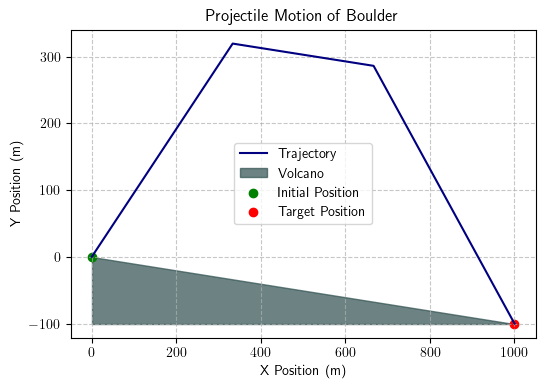

In [28]:
# Extracting x and y values for plotting
x_vals = y_vals[0, :]  # X positions
y_vals_plot = y_vals[1, :]  # Y positions

# Target position (final position of the projectile)
target_pos = (x_end, y_end)

# Plotting the trajectory along with the volcano and target position
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals_plot, label='Trajectory', color='navy')

# Plotting the volcano as a triangle
mountain_x = [0, 0, 1000]  # X coordinates of the triangle vertices
mountain_y = [0, -100, -100]  # Y coordinates of the triangle vertices 
plt.fill(mountain_x, mountain_y, color='darkslategray', alpha=0.7, label='Volcano')

# Plotting the initial and target positions
plt.scatter(0, 0, color='green', label='Initial Position')
plt.scatter(target_pos[0], target_pos[1], color='red', label='Target Position')

# Plot settings
plt.title('Projectile Motion of Boulder')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('relaxation_6.pdf')
plt.show()